<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to build a knowledge graph from a text document. A knowledge graph is a structured representation of information, where entities (such as people, places, or concepts) are represented as nodes, and the relationships between these entities are represented as edges. Knowledge graphs are valuable tools for organizing and extracting insights from large amounts of unstructured text data.


In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
!# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

File ‘bbc_text_cls.csv’ already there; not retrieving.



In [3]:
doc = pd.read_csv("bbc_text_cls.csv")
doc.shape

(2225, 2)

In [4]:
candidate_sentences = doc['text']
candidate_sentences.sample(5)

29      Soaring oil 'hits world economy'\n\nThe soaring cost of oil has hit global economic growth, although world's major economies should weather the storm of price rises, according to the OECD.\n\nIn i...
2107    Hacker threat to Apple's iTunes\n\nUsers of Apple's music jukebox iTunes need to update the software to avoid a potential security threat.\n\nHackers can build malicious playlist files which could...
448     Wal-Mart fights back at accusers\n\nTwo big US names have launched advertising campaigns to "set the record straight" about their products and corporate behaviour.\n\nThe world's biggest retailer ...
919     Brown visits slum on Africa trip\n\nChancellor Gordon Brown has visited Kenya's biggest shantytown as he opened a week-long visit to Africa.\n\nMr Brown's trip is designed to highlight how the UK ...
401     US interest rate rise expected\n\nUS interest rates are expected to rise for the fifth time since June following the US Federal Reserve's latest rate-setting me

 Entities Extraction

In [5]:
#Adapted from kaggle https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent.strip()):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 2225/2225 [02:11<00:00, 16.91it/s]


In [7]:
entity_pairs[:10]

[['advertising It', 'now AOL stake'],
 ['deficit', 'trillion  dollars'],
 ['downfall', 'political founder Mikhail sale'],
 ['flat  shares', '274.5  pence'],
 ['1.8bn Seagram Allied', 'fast food chains'],
 ['Lehman Improvements', 'third job quarter'],
 ['ClearView That', 'new  workers'],
 ['Indian  economy', '8.5  %'],
 ['80  %', 'directly  agriculture'],
 ['%  Reynolds', '4.5  %']]

Relation Extraction

In [8]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1",[pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [9]:
relations = [get_relation(i) for i in tqdm(candidate_sentences)]


100%|██████████| 2225/2225 [01:59<00:00, 18.62it/s]


In [10]:
#check most frequent relations or predicates
pd.Series(relations).value_counts()[:50]

said            298
is              145
added            47
was              40
are              35
have             35
be               33
's               23
has              22
told             20
won              19
think            15
were             15
expected         14
include          13
going            13
is due           12
set              12
made             10
been             10
agreed           10
got              10
says              9
had               9
warned            9
take              9
said in           8
say               8
means             8
lost              7
face              7
is likely         7
put               7
want              7
comes             6
predicted         6
used              6
announced         6
claimed           6
found             5
see               5
be able           5
Replacements      5
seems             5
included          5
need              5
took              5
sent              5
say current       4
closed            4


Build Knowledge Graph

In [11]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,advertising It,now AOL stake,book
1,deficit,trillion dollars,announce
2,downfall,political founder Mikhail sale,claims
3,flat shares,274.5 pence,closed
4,1.8bn Seagram Allied,fast food chains,reduced


In [12]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

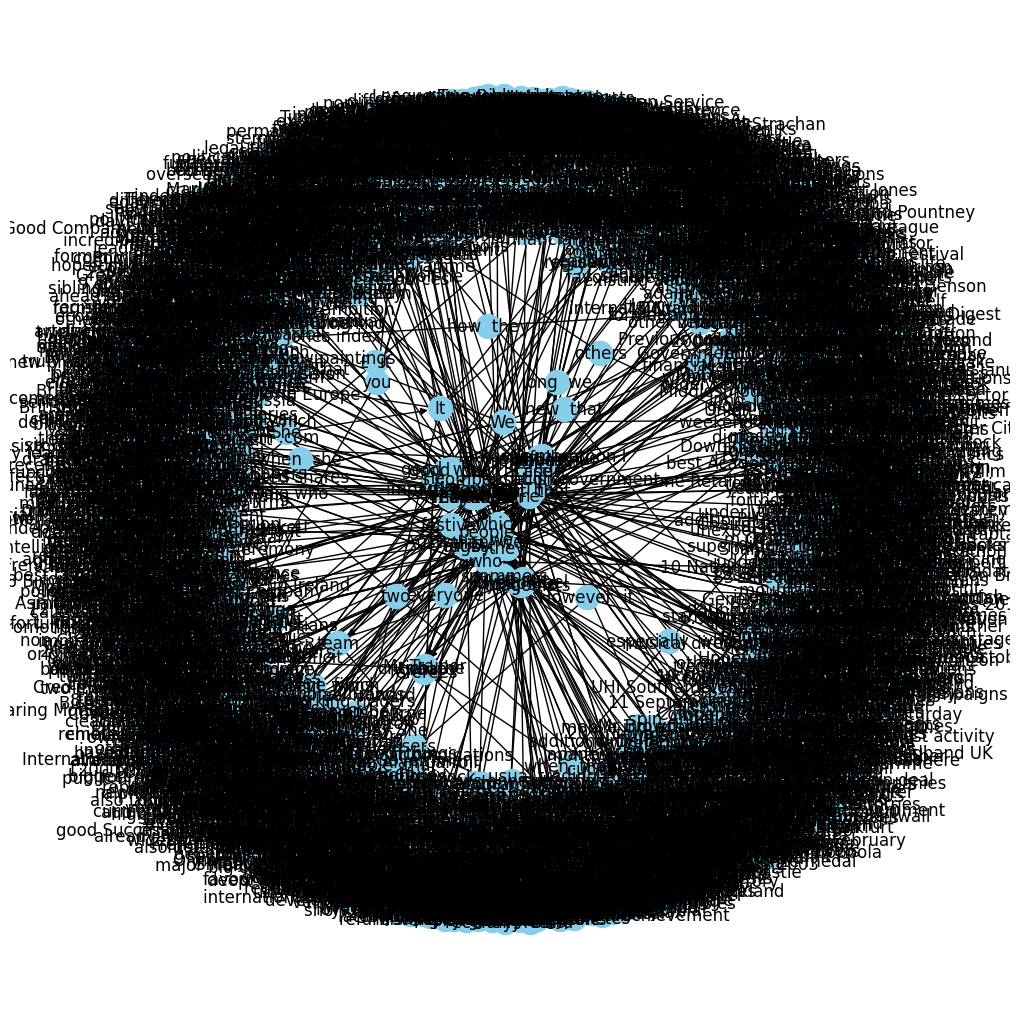

In [13]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

CHECK SOME FEW RELATIONSHIPS INSTEAD

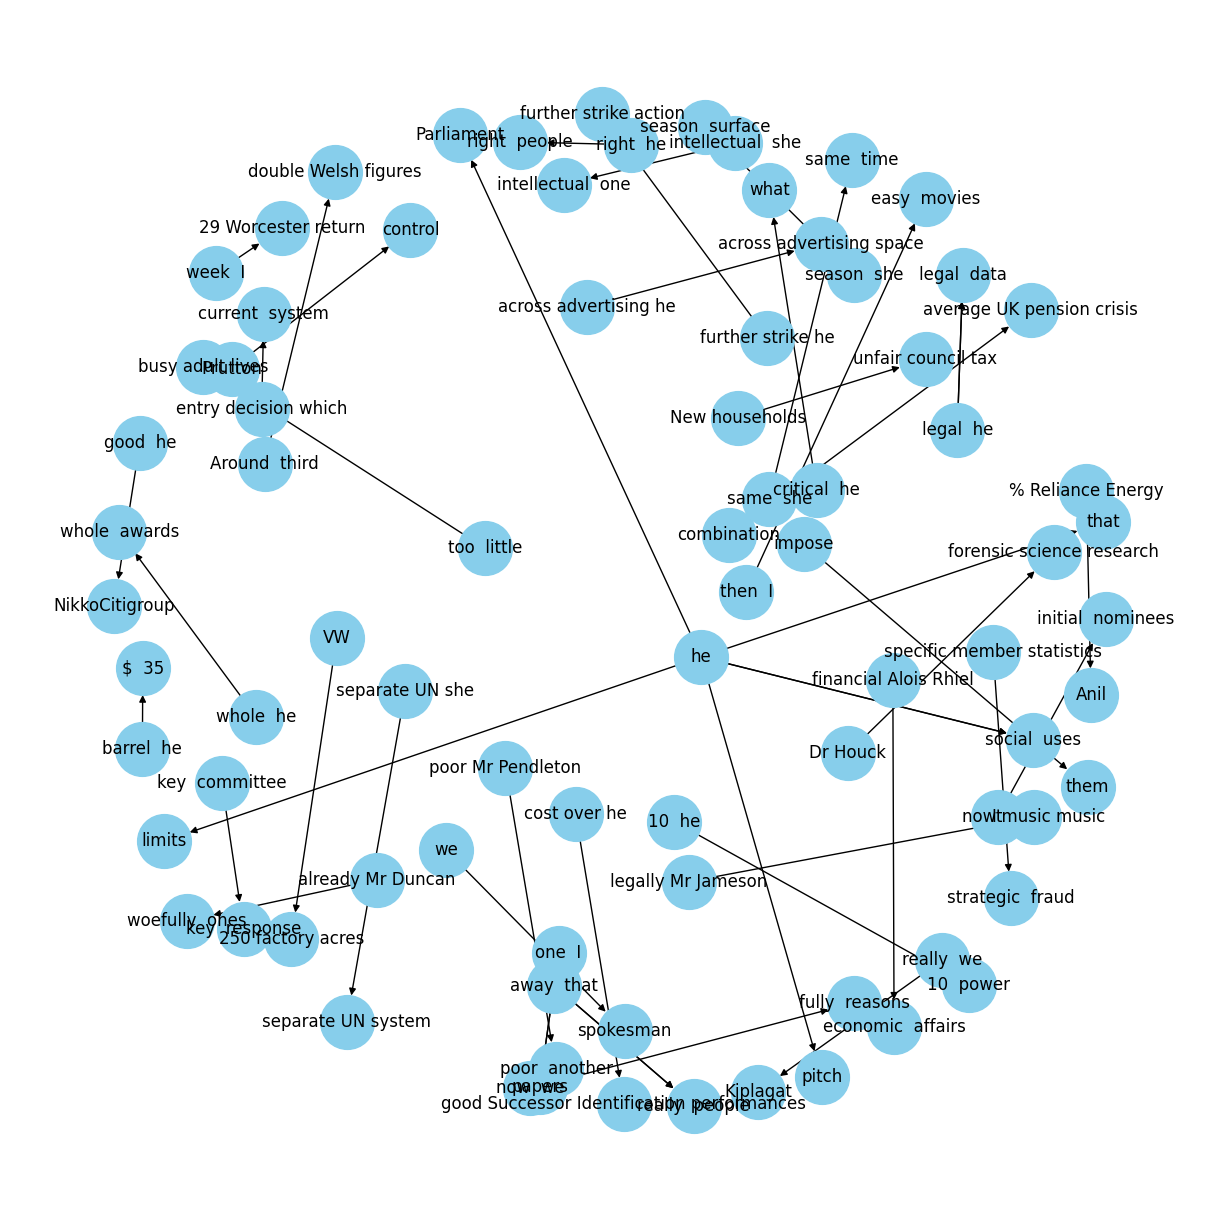

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="added"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

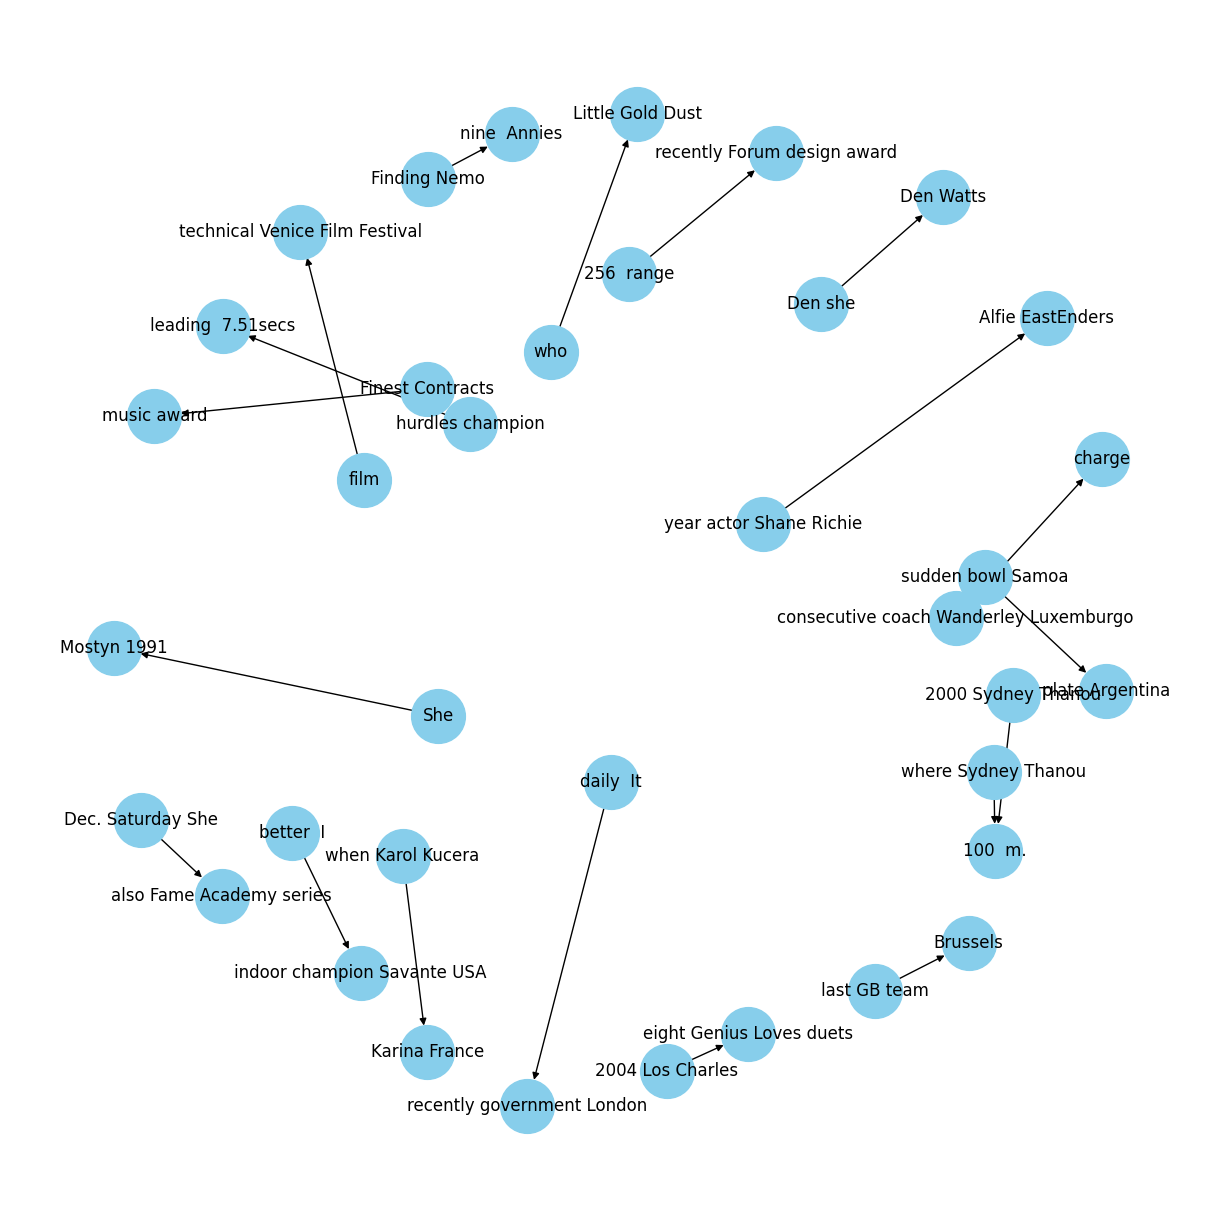

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="won"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()